In [2]:
# !pip install snowflake-connector-python

In [1]:
import os
import sys
import logging
import boto3
import itertools as it
import io
from utils import *
import snowflake.connector

In [2]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import datetime
from datetime import timedelta
import scipy.stats as st

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

In [5]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

# Data Featuring

In [6]:
imdb_votes = run_query('''
 WITH
      imdb_contributor AS (
          SELECT distinct name as contributor_name, 
                 t.title_id, c.category,
                 t.ORIGINAL_TITLE, t.TITLE_TYPE,
                 production_release_date,
                 YEAR as release_year,
                c.billingorder, c.logged_order,
                 max(number_of_votes) as number_of_votes,
                 max(imdb_rating) as imdb_rating
          FROM max_prod.workspace.imdb_title_contributor_billing_logged c
          JOIN "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE" t  ON c.titleid = t.title_id
          where 1=1
          and title_type IN ('tvEpisode', 'movie')
          and category NOT IN ('archive_footage')

          GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
      ),
      yearly_sum as (
      select YEAR as release_year, sum(number_of_votes) as yearly_sum
      from
      "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE"
      GROUP BY YEAR
      having yearly_sum > 0
      )

      SELECT c.contributor_name, c.ORIGINAL_TITLE as title_name, c.category, c.title_type,
             number_of_votes, yearly_sum,
             number_of_votes/yearly_sum * 10000 as standardized_votes,
             imdb_rating,
             production_release_date,
             c.release_year,
             billingOrder,
             number_of_votes/yearly_sum *logged_order * 10000  AS standardized_score
      FROM imdb_contributor c
      JOIN yearly_sum s ON c.release_year = s. release_year
      order by STANDARDIZED_SCORE desc

''')

In [7]:
yearly_sum = run_query('''
      select YEAR as release_year, sum(number_of_votes) as yearly_sum
      from
      "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE"
      where year is not null
      GROUP BY YEAR
      having yearly_sum > 0
''')

In [34]:
imdb_votes.title_type.unique()

array(['movie', 'tvEpisode'], dtype=object)

#### Yearly Trend

No handles with labels found to put in legend.


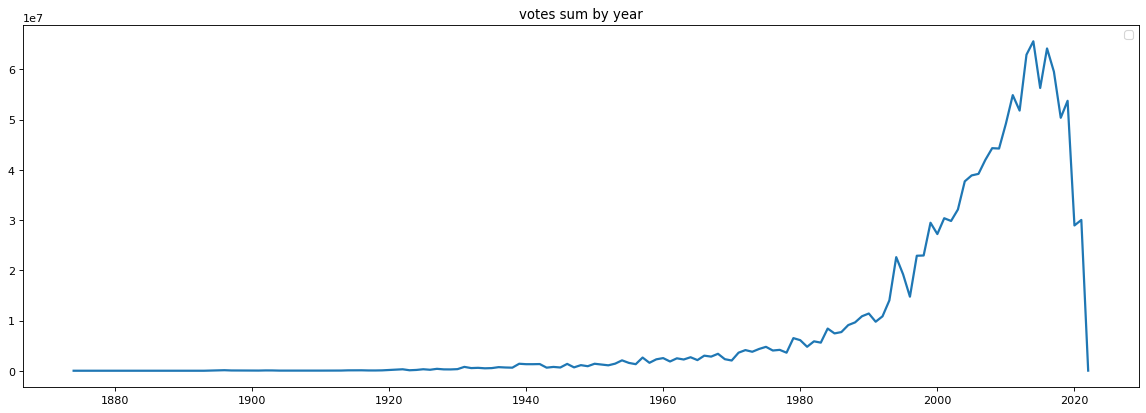

In [19]:
yearly_sum['release_year'] = pd.to_datetime(yearly_sum['release_year'], format='%Y')
yearly_sum.sort_values(by = ['release_year'], inplace = True)

figure(figsize=(18, 6), dpi=80)
plt.plot(yearly_sum['release_year'], yearly_sum['yearly_sum'],
                linewidth=2)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('votes sum by year')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

#### Monthly Trend

In [20]:
monthly_sum = run_query('''
      select date_trunc('MONTH', to_timestamp(production_release_date)) as release_month, 
      sum(number_of_votes) as monthly_sum
      from
      "ENTERPRISE_DATA"."CATALOG"."IMDB_TITLE"
      where year is not null
      GROUP BY release_month
      having monthly_sum > 0
''')

In [21]:
monthly_sum['release_month'] = pd.to_datetime(monthly_sum['release_month'], format='%Y%m')
monthly_sum.sort_values(by = ['release_month'], inplace = True)
monthly_sum = monthly_sum[(monthly_sum['release_month']>= '2016-01-01')
                         &(monthly_sum['release_month']<= '2022-01-01')]


No handles with labels found to put in legend.


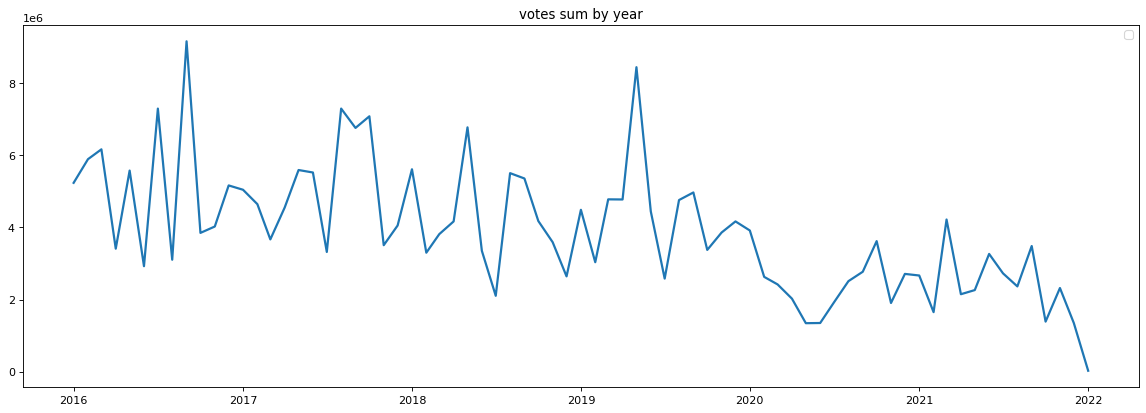

In [22]:
figure(figsize=(18, 6), dpi=80)
plt.plot(monthly_sum['release_month'], monthly_sum['monthly_sum'],
                linewidth=2)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('votes sum by year')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

## Feature Engineering

In [7]:
train_data = imdb_votes[['contributor_name','title_name' ,'release_year','billingorder', 'standardized_score']]

In [9]:
data = train_data.copy()
data['release_year'] = data['release_year'].astype(int)
data['billingorder'] = data['billingorder'].astype(str)
data = data.groupby(['contributor_name', 'release_year']).sum().reset_index()

In [10]:
data1 = data[data['release_year'] > 2000]
data2 = data[data['release_year'] > 1997]
data2.columns = ['contributor_name', 'release_year_before', 'standardized_score_before_']

In [11]:
data = pd.merge(data1, data2, on = ['contributor_name'], how = 'outer')
data=data[(data['release_year'] > data['release_year_before'])
         &(data['release_year'] - 3 <= data['release_year_before'])]

In [12]:
data['years_before'] = data['release_year_before'] - data['release_year']
data['years_before'] = data['years_before'].astype(int).astype(str)
data = data.pivot(index=['contributor_name', 'release_year', 'standardized_score'], 
           columns='years_before', values=['standardized_score_before_']).reset_index()
data.columns = [''.join(col).strip() for col in data.columns.values]

In [13]:
data_order = train_data.copy()
data_order = data_order.groupby(['contributor_name', 'release_year', 'billingorder']).count().reset_index()
data_order = data_order.drop(['title_name'], axis = 1).rename(columns = {'standardized_score': 'count_billingorder_'})
data_order['billingorder'] = data_order['billingorder'].astype(str)
data_order = data_order[(data_order['billingorder'].astype(int)<=3)].pivot(index=['contributor_name', 'release_year'], 
           columns='billingorder', values=['count_billingorder_']).reset_index()
data_order.columns = [''.join(col).strip() for col in data_order.columns.values]
data_order['release_year'] = data_order['release_year'].astype(int)

In [14]:
final_data = pd.merge(data, data_order, how = 'left', on = ['contributor_name', 'release_year'])
final_data = final_data.fillna(0)

In [1]:
final_data.head()

NameError: name 'final_data' is not defined

## Train

In [18]:
from sklearn import datasets, linear_model
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [19]:
year = 2020

In [20]:
feature_cols = ['standardized_score_before_-1', 'standardized_score_before_-2', 'standardized_score_before_-3', 
                'count_billingorder_1', 'count_billingorder_2', 'count_billingorder_3']
target_col = ['standardized_score']

In [21]:
train_X = final_data[final_data['release_year'] < year][feature_cols]
train_Y = final_data[final_data['release_year'] < year][target_col]
test_X = final_data[final_data['release_year'] == year][feature_cols]
test_Y = final_data[final_data['release_year'] == year][target_col]

### xgboost

In [64]:
model_xgb = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1)

In [65]:
model_xgb.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [66]:
predition_xgb = model_xgb.predict(test_X)

In [67]:
test_X['prediction'] = predition_xgb
test_X['actuals'] = test_Y
test_X['mape'] = abs(test_X['prediction']-test_X['actuals'])/test_X['actuals']

In [68]:
test_X[test_X['actuals'] > 0]['mape'].mean()

61.01746777935752

In [45]:
print(model_xgb.feature_importances_)

[0.07949356 0.15106441 0.15819466 0.32801196 0.23750657 0.04572882]


### linear regression

In [48]:
model_lr = linear_model.LinearRegression()

In [49]:
model_lr.fit(train_X, train_Y)

LinearRegression()

In [51]:
prediction_lr = model_lr.predict(test_X)

In [53]:
test_X['prediction'] = prediction_lr
test_X['actuals'] = test_Y
test_X['mape'] = abs(test_X['prediction']-test_X['actuals'])/test_X['actuals']
test_X[test_X['actuals'] > 0]['mape'].mean()

301.70609699082405

### random forest

In [15]:
model_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model_rf.fit(train_X, train_Y)
prediction_rf = model_rf.predict(test_X)

NameError: name 'RandomForestRegressor' is not defined

In [1]:
test_X['prediction'] = prediction_rf
test_X['actuals'] = test_Y
test_X['mape'] = abs(test_X['prediction']-test_X['actuals'])/test_X['actuals']
test_X[test_X['actuals'] > 0]['mape'].mean()

NameError: name 'prediction_rf' is not defined

In [ ]:
print(model_rf.feature_importances_)

In [ ]:
test_X = test_X.sort_values(by = ['prediction'], ascending = False).reset_index(drop = True).reset_index().rename(columns = {'index': 'prediction_ranking'})
test_X = test_X.sort_values(by = ['actuals'], ascending = False).reset_index(drop = True).reset_index().rename(columns = {'index': 'actuals_ranking'})

In [ ]:
def top_k_precision(df, k):
    top_k_df = df[df['actuals_ranking'] < k][['actuals_ranking', 'prediction_ranking']]
    top_k_df['hit'] = 0
    top_k_df.loc[top_k_df['prediction_ranking'] < k, 'hit'] = 1
    return (top_k_df['hit'].sum())

In [ ]:
top_k_precision(test_X, 50)

## Cross Validation

In [22]:
feature_cols = ['standardized_score_before_-1', 'standardized_score_before_-2', 'standardized_score_before_-3', 
                'count_billingorder_1', 'count_billingorder_2', 'count_billingorder_3']
target_col = ['standardized_score']

In [25]:
def predict_score(train, test):
    train_X = train[feature_cols]
    train_Y = train[target_col]
    test_X = test[feature_cols]
    test_Y = test[target_col]
    
    model_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    model_rf.fit(train_X, train_Y)
    prediction_rf = model_rf.predict(test_X)
    
    test['prediction'] = prediction_rf
    test['mape'] = abs(test['prediction']-test['standardized_score'])/test['standardized_score']
    return test

In [26]:
start_year = final_data.release_year.astype(int).min()+3
end_year = final_data.release_year.astype(int).max() + 1

In [ ]:
train_df = pd.DataFrame()
for year in range(start_year, end_year):
    print ('cross validation for year: ' + str(year))
    train = final_data[(final_data['release_year'] < year)
                      &(final_data['release_year'] >= year - 3)]
    test = final_data[final_data['release_year'] == year]
    
    output = predict_score(train, test)
    train_df = pd.concat([train_df, output])

cross validation for year: 2004


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2005


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2006


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2007


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2008


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2009


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2010


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2011


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2012


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2013


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2014


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2015


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2016


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2017


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2018


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2019


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


cross validation for year: 2020


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [30]:
# train_df.to_csv('train_df.csv')
train_df = pd.read_csv('train_df.csv')
train_df.drop(['Unnamed: 0'], inplace = True, axis =1)

In [31]:
train_df= train_df[train_df['release_year'] < 2022]

In [32]:
mape_df = pd.DataFrame(train_df[train_df['standardized_score']>0].groupby(['release_year']).mape.mean()).reset_index()

No handles with labels found to put in legend.


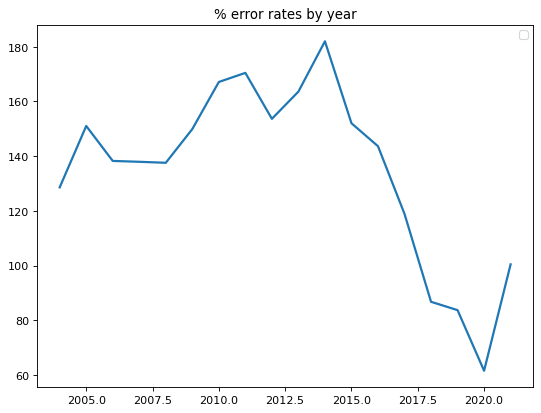

In [33]:
figure(figsize=(8, 6), dpi=80)
plt.plot(mape_df['release_year'], mape_df['mape'],
                linewidth=2)
# plt.fill_between(plot_df['days_after_launch'], plot_df['lower_bound'], plot_df['upper_bound'], color='b', alpha=.1)
plt.title('% error rates by year')
# plt.ylim(0, 18)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [34]:
train_df['prediction_ranking'] = train_df.groupby("release_year")["prediction"].rank("dense", ascending=False)
train_df['actuals_ranking'] = train_df.groupby("release_year")["standardized_score"].rank("dense", ascending=False)

In [35]:
def top_k_precision(df, k):
    top_k_df = df[df['actuals_ranking'] < k][['actuals_ranking', 'prediction_ranking']]
    top_k_df['hit'] = 0
    top_k_df.loc[top_k_df['prediction_ranking'] < k, 'hit'] = 1
    return (top_k_df['hit'].sum())

In [36]:
top_hit_50 = pd.DataFrame(train_df.groupby(['release_year']).apply(lambda df: top_k_precision(df, 50)))
top_hit_50 = top_hit_50.reset_index().rename(columns = {0:'hits'})

No handles with labels found to put in legend.


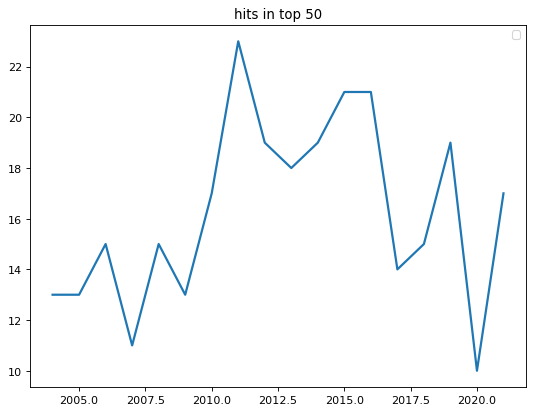

In [37]:
figure(figsize=(8, 6), dpi=80)
plt.plot(top_hit_50['release_year'], top_hit_50['hits'],
                linewidth=2)
plt.title('hits in top 50')
plt.legend()
plt.show()

## Prediction

In [38]:
prediction_year = 2022

In [39]:
test_data = imdb_votes[['contributor_name','title_name' ,'release_year','billingorder', 'standardized_score']]

In [40]:
data = test_data.copy()
data['release_year'] = data['release_year'].astype(int)
data = data[data['release_year'] >= prediction_year - 3]
data['billingorder'] = data['billingorder'].astype('str')
data = data.groupby(['contributor_name', 'release_year']).sum().reset_index()

In [41]:
data.columns = ['contributor_name', 'release_year_before', 'standardized_score_before_']

In [42]:
data['release_year'] = prediction_year

In [43]:
data['years_before'] = data['release_year_before'] - data['release_year']
data = data[data['years_before'] < 0]
data['years_before'] = data['years_before'].astype(str)
data = data.pivot(index=['contributor_name', 'release_year'], 
           columns='years_before', values=['standardized_score_before_']).reset_index()
data.columns = [''.join(col).strip() for col in data.columns.values]

In [44]:
data_order = test_data[test_data['release_year'].astype(int) == prediction_year].copy()
data_order = data_order.groupby(['contributor_name', 'release_year', 'billingorder']).count().reset_index()
data_order = data_order.drop(['title_name'], axis = 1).rename(columns = {'standardized_score': 'count_billingorder_'})
data_order['billingorder'] = data_order['billingorder'].astype(str)
data_order = data_order[(data_order['billingorder'].astype(int)<=3)].pivot(index=['contributor_name', 'release_year'], 
           columns='billingorder', values=['count_billingorder_']).reset_index()
data_order.columns = [''.join(col).strip() for col in data_order.columns.values]
data_order['release_year'] = data_order['release_year'].astype(int)

In [45]:
final_test_data = pd.merge(data, data_order, how = 'left', on = ['contributor_name', 'release_year'])
final_test_data = final_test_data.fillna(0)

In [46]:
final_train_data = final_data[final_data['release_year'] >= 2016]

In [ ]:
model_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model_rf.fit(final_train_data[feature_cols], final_train_data[target_col])
prediction_rf = model_rf.predict(final_test_data[feature_cols])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [ ]:
final_test_data['prediction'] = prediction_rf

In [ ]:
final_test_data.sort_values(by = ['prediction'], ascending = False).head(20)

# Caveats

#### 1. Can only use by year (becuase of yearly standarization)
#### 1. Can only use by year (becuase of yearly standarization)